# Import

In [1]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
# 한글 폰트가 깨지면 실행하세요! 
# 한글 폰트가 따로 깔려있지 않은 컴퓨터에서는 해당 cell을 넘겨주세요!!! 
import matplotlib.font_manager as fm
fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
fontlist[:]

from matplotlib import font_manager, rc
#font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 1. Data Load  

**치매 예방을 위한 라이프로그 치매 분류**

**9,327 rows × 66 columns**

For more details https://aihub.or.kr/problem_contest/nipa-learning-platform/6

In [3]:
path = "./Dataset/"

# original data : data 
data =  pd.read_csv(path + "dementia_data.csv", parse_dates=['summary_date']) # 애초에 datatime 유형의 데이터를 읽어 올 때부터 형변환하기
data

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,...,3863,3,735,2,...,-0.16,99.99,NaN,\r,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,...,4411,1,780,4,...,-0.09,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,...,11057,1,518,1,...,0.41,99.99,NaN,\r,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,...,5135,4,578,0,...,0.27,99.99,NaN,\r,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


# 2. EDA  

**9,327 rows × 66 columns**

148명에 대한 데일리 라이프로그 데이터 
크게 걸음거리, 수면, 컨버팅 데이터로 나눌 수 있겠습니다. 

**basic (3 cols)**
- timezone 시간 장소 정보 
    - drop 
    - 완벽한 null variable 
- EMAIL
    - drop
    - 식별자 feature 
- summary_date

**activity (26 cols)**
- activity_class_5min, activity_met_1min, 하루간 5분당 활동 로그,하루간 1분당 MET 로그
    - drop 
    - BLOB type -> js로 읽을 수 있다고는 함 

**sleep (31 cols)**
- sleep_is_longest, 본 수면 여부 
    - 전부 다 1 
- sleep_temperature_trend_deviation, 피부 온도 경향 편차 
    - 전부 다 99.99
- sleep_total, 수면 시간 
    - 전부 다 \r
- sleep_temperature_deviation 
    - drop 
    - sleep_temperature_delta 랑 같은 변수 
    - sleep_temperature_deviation 을 drop 하고 delta를 남길 것 
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - 5분 당 심박동로그, 수면 상태 로그, 5분당 심박동변동 로그
    - drop 
    - BLOB type 

**converting**
- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    
So we may use 56 columns for training...

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   EMAIL                                     9327 non-null   object        
 1   summary_date                              9327 non-null   datetime64[ns]
 2   activity_average_met                      9327 non-null   float64       
 3   activity_cal_active                       9327 non-null   int64         
 4   activity_cal_total                        9327 non-null   int64         
 5   activity_class_5min                       9327 non-null   object        
 6   activity_daily_movement                   9327 non-null   int64         
 7   activity_high                             9327 non-null   int64         
 8   activity_inactive                         9327 non-null   int64         
 9   activity_inactivity_alerts    

# 3. Preprocessing 

**9,327 rows × 66 columns**

**9,327 rows × 51 columns**


**feature drop**
- timezone
- EMAIL
- sleep_temperature_trend_deviation, sleep_is_longest, sleep_total
    - 모든 값이 1, '\r', 99.99 이므로 제거 
- sleep_temperature_deviation
    - sleep_temperature_delta 변수와 중복되므로 deviation 변수를 제거
- activity_class_5min, activity_met_1min
    - convert data
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - convert data


- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    
So we may use 49 columns for training...

In [230]:
# data를 따로 관리합니다 
# original data -> data 
# preprocessing data -> processed_data
processed_data = data.copy()

In [231]:
# Feature Selection - column drop 
# drop 할 column을 아래와 같이 묶어서 정리합니다 
# summary_date 추가 
drop_cols = ['timezone', 'EMAIL',
             'activity_class_5min', 'activity_met_1min', 
             'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min',
             'sleep_is_longest', 'sleep_temperature_trend_deviation', 'sleep_total', 'sleep_temperature_deviation',
             'summary_date']
convert_cols = data.iloc[:, 60:65].columns

processed_data = processed_data.drop(drop_cols, axis=1)
processed_data = processed_data.drop(convert_cols, axis=1)
# 9327 x 49 

In [221]:
# right skewed -> log transform -> 13개 
# left skewed -> quantile transform -> 8개
# sleep_midpoint_delta -> log tranform에서 error 남 => 제외했음 
# https://yashowardhanshinde.medium.com/what-is-skewness-in-data-how-to-fix-skewed-data-in-python-a792e98c0fa6
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer, power_transform, QuantileTransformer 

def quantileTransform(data) : 
    qt = QuantileTransformer()
    scaled_data = pd.DataFrame(qt.fit_transform(data), columns=data.columns)
    return scaled_data

def logTransform(data) :
    scaled_cols = data.columns
    scaled_data = data.apply(lambda x: np.log1p(x))
    return scaled_data

left_skewed_cols = ['sleep_efficiency', 'sleep_score_alignment', 'sleep_score_deep', 'sleep_score_latency', 'sleep_score_total',
                    'activity_score', 'activity_score_stay_active', 'activity_score_training_volume']
right_skewed_cols = ['activity_cal_active', 'activity_daily_movement', 'activity_high', 'activity_medium', 'activity_met_min_high', 
                     'activity_met_min_inactive', 'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear', 
                     'activity_steps', 'sleep_awake', 'sleep_onset_latency', 'sleep_rmssd']

print(len(left_skewed_cols))
print(len(right_skewed_cols))

processed_data[left_skewed_cols] = quantileTransform(processed_data[left_skewed_cols])
processed_data[right_skewed_cols] = logTransform(processed_data[right_skewed_cols])
processed_data.head()

8
13


,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,1.71875,6.594413,2944,9.571296,0.0,417,0,545,3.871201,0.0,...,62,1.0,0.112112,50,27,0.912913,66,0.304304,-0.12,CN
1,1.40625,5.837730,2449,8.756682,0.0,473,0,392,2.197225,0.0,...,54,1.0,0.140140,43,46,0.763263,35,0.112112,-0.32,CN
2,1.46875,5.996452,2544,8.895356,0.0,586,0,362,3.218876,0.0,...,61,1.0,0.177177,47,34,0.687688,41,0.304304,0.07,CN
3,0.34375,3.332205,1850,6.198479,0.0,176,0,34,0.693147,0.0,...,55,1.0,0.085586,40,44,0.621622,29,0.226727,-0.41,CN
4,1.46875,5.811141,2518,8.676246,0.0,646,0,377,1.945910,0.0,...,56,1.0,0.217217,55,39,0.008577,54,0.264765,-0.27,CN


In [222]:
standardScaler = RobustScaler()
scaled_data = processed_data.iloc[:, :48].copy()
scaled_data = pd.DataFrame(standardScaler.fit_transform(scaled_data), columns = scaled_data.columns)
processed_data.iloc[:, :48]=scaled_data

processed_data.head()

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,1.285714,0.665495,1.086168,0.668473,-0.5,-0.527174,0.0,1.658537,0.075683,-0.663194,...,-0.8125,0.0,-0.807365,-0.941176,-1.857143,0.750000,0.188679,-0.395137,-0.342857,CN
1,-0.142857,-0.231609,-0.036281,-0.233596,-0.5,-0.222826,0.0,0.725610,-1.076056,-0.663194,...,-1.3125,0.0,-0.754485,-1.352941,-1.178571,0.479167,-0.396226,-0.784195,-0.914286,CN
2,0.142857,-0.043432,0.179138,-0.080035,-0.5,0.391304,0.0,0.542683,-0.373133,-0.663194,...,-0.8750,0.0,-0.684608,-1.117647,-1.607143,0.342391,-0.283019,-0.395137,0.200000,CN
3,-5.000000,-3.202093,-1.394558,-3.066443,-0.5,-1.836957,0.0,-1.457317,-2.110900,-0.663194,...,-1.2500,0.0,-0.857413,-1.529412,-1.250000,0.222826,-0.509434,-0.552178,-1.171429,CN
4,0.142857,-0.263132,0.120181,-0.322668,-0.5,0.717391,0.0,0.634146,-1.248967,-0.663194,...,-1.1875,0.0,-0.609065,-0.647059,-1.428571,-0.886651,-0.037736,-0.475177,-0.771429,CN


In [135]:
from sklearn.decomposition import PCA

processed_data_y = processed_data['DIAG_NM']
processed_data_X = processed_data.drop('DIAG_NM', axis=1)

pca = PCA(n_components=4)
processed_data_X = pca.fit_transform(processed_data_X)
processed_data_X = pd.DataFrame(processed_data_X)

processed_data = pd.concat([processed_data_X, processed_data_y], axis=1)
processed_data

,0,1,2,3,DIAG_NM
0,-2272.167797,-4082.705104,10869.621333,5460.303368,CN
1,-1873.906100,2416.942852,-5907.759760,1302.340460,CN
2,-3274.713459,-7894.290564,1073.547860,3663.760972,CN
3,-2363.280486,-6632.427668,-5017.978415,793.079395,CN
4,-3301.608111,-6596.087116,-1586.732328,3761.377515,CN
...,...,...,...,...,...
9322,-212.661636,-8805.395903,-3942.173720,-2286.131025,CN
9323,-631.071246,-9610.555311,-2620.013956,-3518.688165,CN
9324,-1361.451197,1315.911394,2094.558774,-3105.802547,CN
9325,2621.706626,-10860.591238,-305.533632,-6249.076234,CN


# 4. Data Split 

모든 전처리와 y variable labeling이 완료되었다. train / valid / test data로 분할하고 용도에 맞게 model을 돌리도록 하자. 

In [232]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# data를 따로 관리합니다 
# preprocessing data -> processed_data
# input data -> input_data
input_data = processed_data.copy()

# y 변수와 X 변수 분할 관리 
input_data_y = input_data['DIAG_NM'].copy()
input_data_X = input_data.drop(['DIAG_NM'], axis=1)

In [233]:
# LabelEncoder
# y data를 LabelEncdoer로 한 번 더 labeling 합니다 -> 100만원, 10000만원... = 0, 1, ... 
# 추후에 DL에서 output을 맞춰주기 위함입니다, 최종 마지막에서 원래 label값(100만원, 1000만원...)으로 되돌립니다
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data_y = le.fit_transform(list(input_data_y))
print("original gain_label \n", le.classes_)
print("gain_lable label \n", set(input_data_y))

original gain_label 
 ['CN' 'Dem' 'MCI']
gain_lable label 
 {0, 1, 2}


In [234]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

# 5. Modeling - ML

- Linear model
    - **Logistic Linear Regression** 
    - solver : newton-cg, lbfgs, sag, saga (sag, saga는 데이터가 클 때 좋음) 
    - newton-cg - (l2, none), lbfgs - (l2, none),  
    - 이중 분류가 아니기 때문에 'liblinear' optimizer를 사용할 수 없음
    - multi_class : default = auto, 현재는 multinomial 
- Tree model 
    - decision Tree (pruning)
    - RandomForest (Ensemble model?)
- Gradient Boosting model 
    - XGB
    - LGBM
    - CatBoost 

In [226]:
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
from lightgbm import plot_importance 
from xgboost import XGBClassifier
from xgboost import plot_importance
# Learning task parameters
# multi:softmax : softmax를 이용한 다중 클래스 분류 
# multi:softptob : softmax를 이용한 다중 클래스에 대한 예상 확률 반환 
# mlogloss : multiclass logloss 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score

### logistic regression

In [210]:
model_lr = LogisticRegression(max_iter=1000, solver='newton-cg')

In [211]:
# warning : 'max_iter'까지 학습했으나 정답에 수렴하지 못한 상태 
# warning : https://www.inflearn.com/questions/62388 -> 철민이형 답변 
# warning : For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga', 'lbfgs’ handle multinomial loss
# warning : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
model_lr.fit(tr_val_X, tr_val_y)

LogisticRegression(max_iter=1000, solver='newton-cg')

In [212]:
print(model_lr.score(tr_val_X, tr_val_y))
print(model_lr.score(test_X, test_y))

0.6815440289505428
0.665058949624866


In [213]:
# https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/ 
# logistic regression interpretability 
w0 = model_lr.intercept_[0]
w = model_lr.coef_[0]

<AxesSubplot:xlabel='importance', ylabel='feature'>

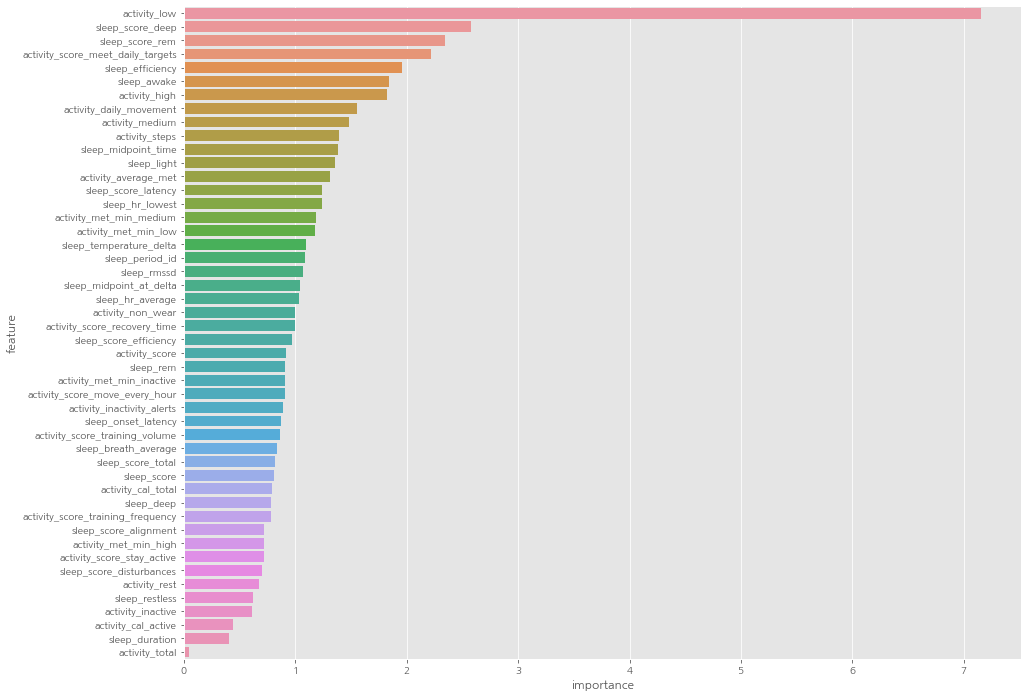

In [214]:
feature_importance = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance, x="importance", y="feature")

In [215]:
# feature importance 가 1 이하인 것들을 제거해보고 진행해봅니다 
# 23개의 feature가 drop 되고 48개에서 25개만 남게 되겠네요
not_necessary = feature_importance[feature_importance["importance"]<1]["feature"].values
print(len(not_necessary))
print(not_necessary)

25
['activity_score_recovery_time' 'sleep_score_efficiency' 'activity_score'
 'sleep_rem' 'activity_met_min_inactive' 'activity_score_move_every_hour'
 'activity_inactivity_alerts' 'sleep_onset_latency'
 'activity_score_training_volume' 'sleep_breath_average'
 'sleep_score_total' 'sleep_score' 'activity_cal_total' 'sleep_deep'
 'activity_score_training_frequency' 'sleep_score_alignment'
 'activity_met_min_high' 'activity_score_stay_active'
 'sleep_score_disturbances' 'activity_rest' 'sleep_restless'
 'activity_inactive' 'activity_cal_active' 'sleep_duration'
 'activity_total']


feature selection 끝! 

In [216]:
input_data_X2 = input_data_X.drop(not_necessary, axis=1)
input_data_X2.head()

,activity_average_met,activity_daily_movement,activity_high,activity_low,activity_medium,activity_met_min_low,activity_met_min_medium,activity_non_wear,activity_score_meet_daily_targets,activity_steps,...,sleep_hr_lowest,sleep_light,sleep_midpoint_at_delta,sleep_midpoint_time,sleep_period_id,sleep_rmssd,sleep_score_deep,sleep_score_latency,sleep_score_rem,sleep_temperature_delta
0,1.285714,0.668473,-0.5,1.658537,0.075683,1.253033,0.155530,0.428226,0.000,0.583640,...,0.777778,0.070707,-0.251153,0.630872,-1.0,-0.762422,-0.807365,0.750000,0.188679,-0.342857
1,-0.142857,-0.233596,-0.5,0.725610,-1.076056,0.483671,-1.065624,0.406597,-0.425,-0.277080,...,0.888889,-0.404040,0.305631,-0.664430,-1.0,-0.857935,-0.754485,0.479167,-0.396226,-0.914286
2,0.142857,-0.080035,-0.5,0.542683,-0.373133,0.432317,-0.328072,0.157293,0.000,-0.189502,...,0.444444,0.196970,-0.434795,0.671141,-1.0,-0.270445,-0.684608,0.342391,-0.283019,0.200000
3,-5.000000,-3.066443,-0.5,-1.457317,-2.110900,-3.125917,-2.267144,0.314586,0.000,-0.221490,...,0.222222,0.292929,-0.170901,0.288591,-1.0,0.000000,-0.857413,0.222826,-0.509434,-1.171429
4,0.142857,-0.322668,-0.5,0.634146,-1.248967,0.432317,-1.211927,0.314586,0.000,-0.336994,...,0.555556,-0.101010,-0.347221,0.617450,-1.0,-0.501019,-0.609065,-0.886651,-0.037736,-0.771429


In [217]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X2, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

In [218]:
model_lr = LogisticRegression(max_iter=1000, solver='newton-cg')
model_lr.fit(tr_val_X, tr_val_y)

print(model_lr.score(tr_val_X, tr_val_y))
print(model_lr.score(test_X, test_y))

0.6508510923468704
0.6484458735262594


중요도 낮은 feature를 pca로 묶어버리기 

In [200]:
pca = PCA(n_components=4)
pca_data = pca.fit_transform(input_data_X[not_necessary])
pca_data = pd.DataFrame(pca_data)

input_data_X = input_data_X.drop(not_necessary, axis=1)
input_data_X = pd.concat([input_data_X, pca_data], axis=1)
input_data_X

,activity_cal_active,activity_daily_movement,activity_high,activity_inactive,activity_low,activity_non_wear,activity_rest,activity_score_meet_daily_targets,activity_score_recovery_time,activity_score_stay_active,...,sleep_score_deep,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,0,1,2,3
0,730,14346,0,417,545,32,399,95,100,86,...,41,27,97,66,62,-0.12,8745.781720,5205.146185,-2217.055436,-129.982015
1,342,6352,0,473,392,29,538,78,100,83,...,49,46,91,35,44,-0.32,-3666.413467,3478.161454,-1003.884596,-135.760461
2,401,7297,0,586,362,9,459,95,100,71,...,56,34,89,41,62,0.07,5743.947920,4793.364710,-612.371108,177.677910
3,27,491,0,176,34,19,1210,95,100,74,...,35,44,86,29,56,-0.41,1566.914313,4112.081227,-17.252671,306.445278
4,333,5861,0,646,377,19,392,95,100,65,...,64,39,14,54,59,-0.27,3812.479386,3925.581880,-1457.715594,2411.314682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,227,3863,3,735,155,0,530,43,100,49,...,53,74,97,84,82,-0.16,3776.910422,-1090.990063,-861.533231,52.362351
9323,249,4411,1,780,167,0,470,25,100,45,...,34,76,81,95,86,-0.09,4314.371906,-1928.102964,-1195.039789,-303.342512
9324,570,11057,1,518,332,0,528,43,100,76,...,1,69,86,89,64,0.41,-1081.506508,-598.825466,-2319.799570,-185.272605
9325,295,5135,4,578,173,0,655,25,100,70,...,9,86,89,98,97,0.27,6146.706837,-3876.112537,-1455.732410,417.369144


In [201]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

model_lr = LogisticRegression(max_iter=1000, solver='newton-cg')
model_lr.fit(tr_val_X, tr_val_y)

print(model_lr.score(tr_val_X, tr_val_y))
print(model_lr.score(test_X, test_y))

C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Hyeongbin\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


0.6629138185229861
0.662379421221865


C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### Random Forest

In [235]:
model_rf = RandomForestClassifier()

In [236]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_rf.fit(x_train, y_train)
    pred = model_rf.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4816,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6421,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5643,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5617,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5328,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.5565


In [237]:
pred_rf = model_rf.predict(test_X)
print(classification_report(test_y, pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1194
           1       0.96      0.81      0.88       129
           2       0.92      0.70      0.79       543

    accuracy                           0.88      1866
   macro avg       0.91      0.83      0.86      1866
weighted avg       0.88      0.88      0.87      1866



### XGB, LGBM

In [238]:
model_xgb = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False )
#model_lgbm = LG### Random ForestBMClassifier()

In [239]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_xgb.fit(x_train, y_train)
    pred = model_xgb.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4796,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6193,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5181,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5536,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5228,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.53868


In [240]:
pred_xgb_prob = model_xgb.predict_proba(test_X)
pred_xgb = np.argmax(pred_xgb_prob, axis=1)

print(classification_report(test_y, pred_xgb))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1194
           1       0.87      0.85      0.86       129
           2       0.86      0.73      0.79       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.85      1866
weighted avg       0.87      0.87      0.87      1866



In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_lgbm.fit(x_train, y_train)
    pred = model_lgbm.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4776,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6448,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5349,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5436,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5295,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.5460800000000001


In [18]:
pred_lgbm_prob = model_lgbm.predict_proba(test_X)
pred_lgbm = np.argmax(pred_lgbm_prob, axis=1)

print(classification_report(test_y, pred_lgbm))

# 6. Evaluation

- precision(정밀도) : True -> True 
- Recall(재현율) : True인 것을 맞춘 비율 
- F1 score : precision 과 recall의 조화평균

In [18]:
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

<AxesSubplot:>

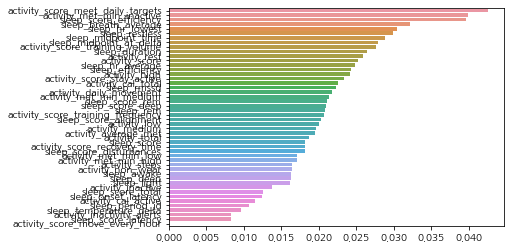

In [23]:
feature_series = pd.Series(data=model_xgb.feature_importances_, index=tr_val_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

<AxesSubplot:>

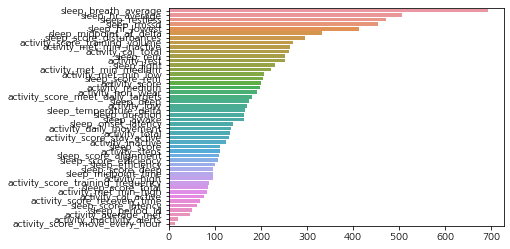

In [24]:
feature_series = pd.Series(data=model_lgbm.feature_importances_, index=tr_val_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)